In [13]:
import os
import glob
import pydicom
import nibabel as nib
import pandas as pd
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from tqdm import tqdm


import sys

sys.path.append("..")

from utils.dcm_utils import *
from utils.nii_utils import *
from utils.train_utils import *

%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.io import read_image
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, CenterCrop
import torchvision.transforms.functional as TF

In [20]:
DATA_DIR = "/Volumes/SSD970/"
# DATA_DIR = "/media/longyi/SSD9701/"
TRAIN_XRAY_DIR = os.path.join(DATA_DIR, "xray_images")
TRAIN_IMAGE_DIR = os.path.join(DATA_DIR, "train_images")


In [31]:
UID = "1.2.826.0.1.3680043.171"
imgs, image_positions, image_orientations, pixel_spacings, slice_thicknesses, is_flip = read_patient_dcm(os.path.join(TRAIN_IMAGE_DIR, UID))

375
(375, 3)


In [27]:
def print_min_max(data):
    print(f"{data.min()} {data.max()}")

In [32]:
norm_imgs = normalize_hu(imgs)
print_min_max(norm_imgs)

-0.00022311468094604603 1.0002231146809462


In [33]:
model = torchvision.models.resnet18(pretrained=True)
model

/Users/longyikim/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/longyikim/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [43]:
conv1_weight = model.conv1.weight
conv1_weight.shape
new_conv1_weight = conv1_weight.mean(dim=1).unsqueeze(1)
new_conv1_weight.shape
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=2, padding=3, bias=False)
model.conv1.weight = nn.Parameter(new_conv1_weight, requires_grad=True)
model.fc = nn.Linear(512, 8, bias=True)

In [35]:
def layer_input_output(model, module, model_input, grad=False):
    """

    :param model:
    :param module:
    :param input:
    :param grad:
    :return: input, output of the module
    """
    activation = []
    def forward_hook_fn(module, module_input, module_output):
        activation.append(module_output)
        activation.append(module_input)

    handle = module.register_forward_hook(forward_hook_fn)
    model.eval()

    if grad is False:
        with torch.no_grad():
            model(model_input)
    else:
        model(model_input)
    handle.remove()
    return activation.pop()[0], activation.pop()

In [41]:
input_tensor = torch.tensor(norm_imgs[[150], :, :]).unsqueeze(0).float()
input_tensor.shape

torch.Size([1, 1, 512, 512])

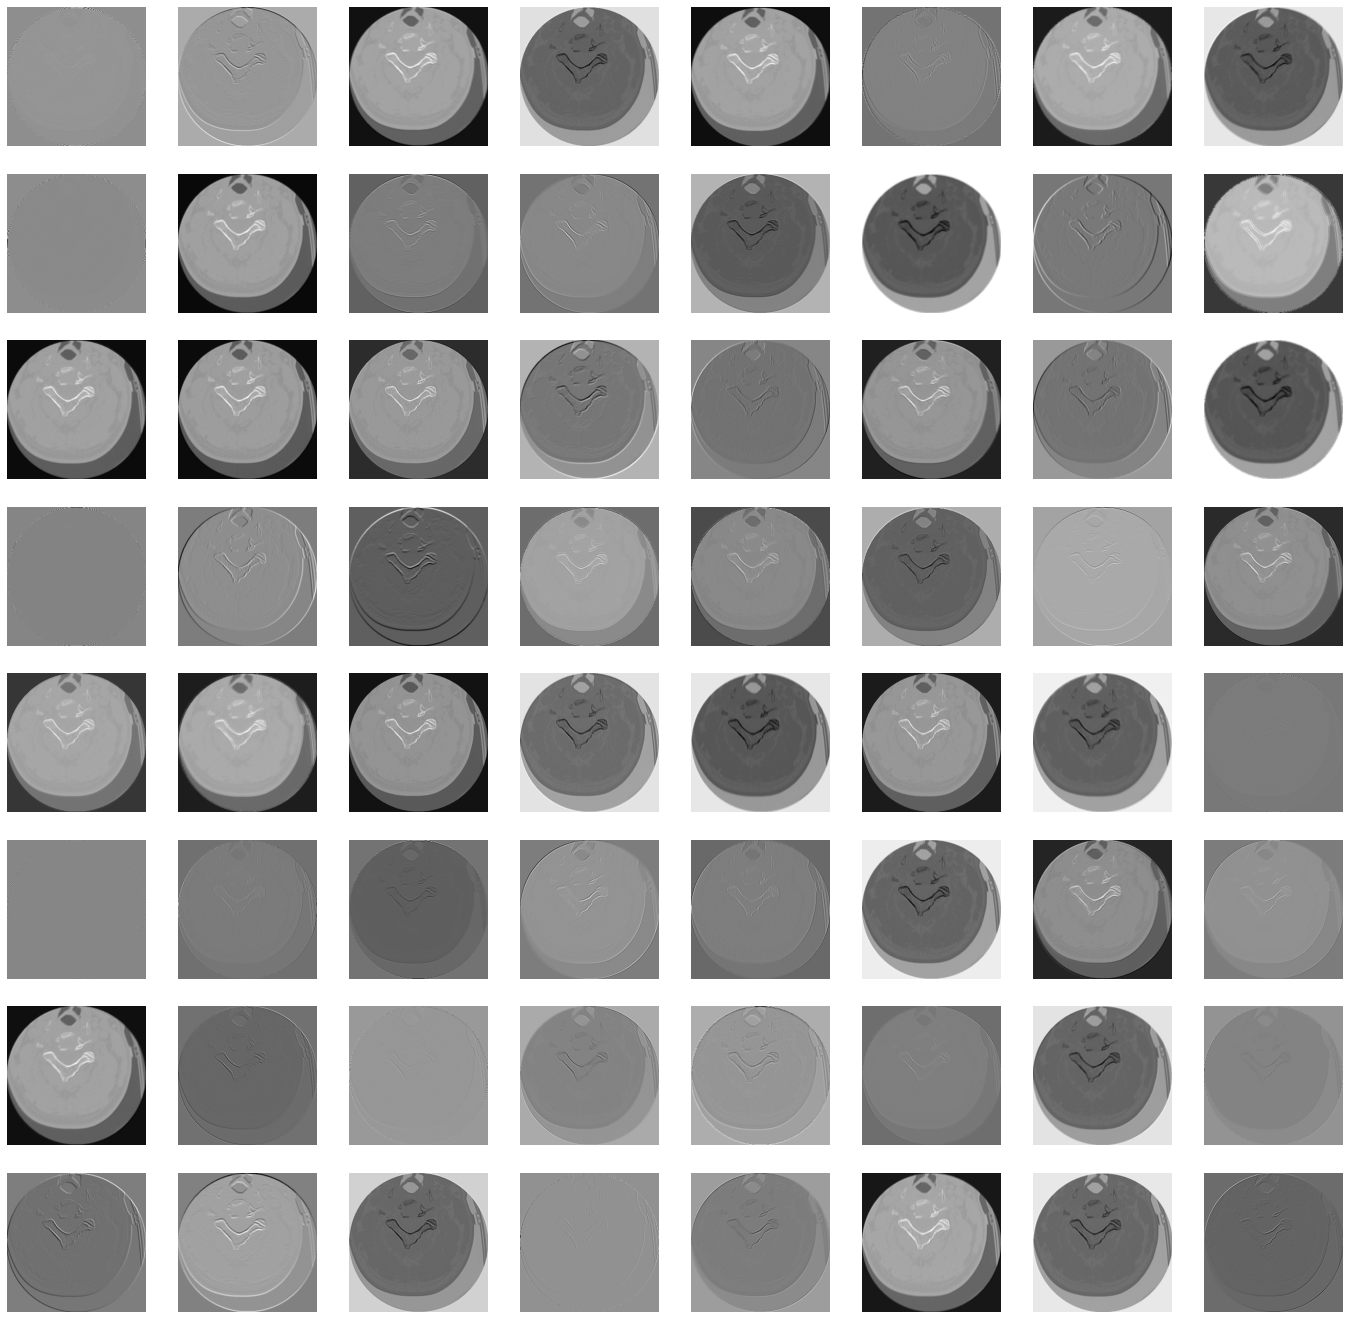

In [63]:
module_input, module_output = layer_input_output(model, model.conv1, torch.tensor(norm_imgs[[150], :, :]).unsqueeze(0).float())
fig, ax = plt.subplots(8, 8, figsize=(24, 24))
for i in range(64):
    ax[i // 8, i % 8].axis('off')
    ax[i // 8, i % 8].imshow(module_output[0, i, :, :], cmap='gray')

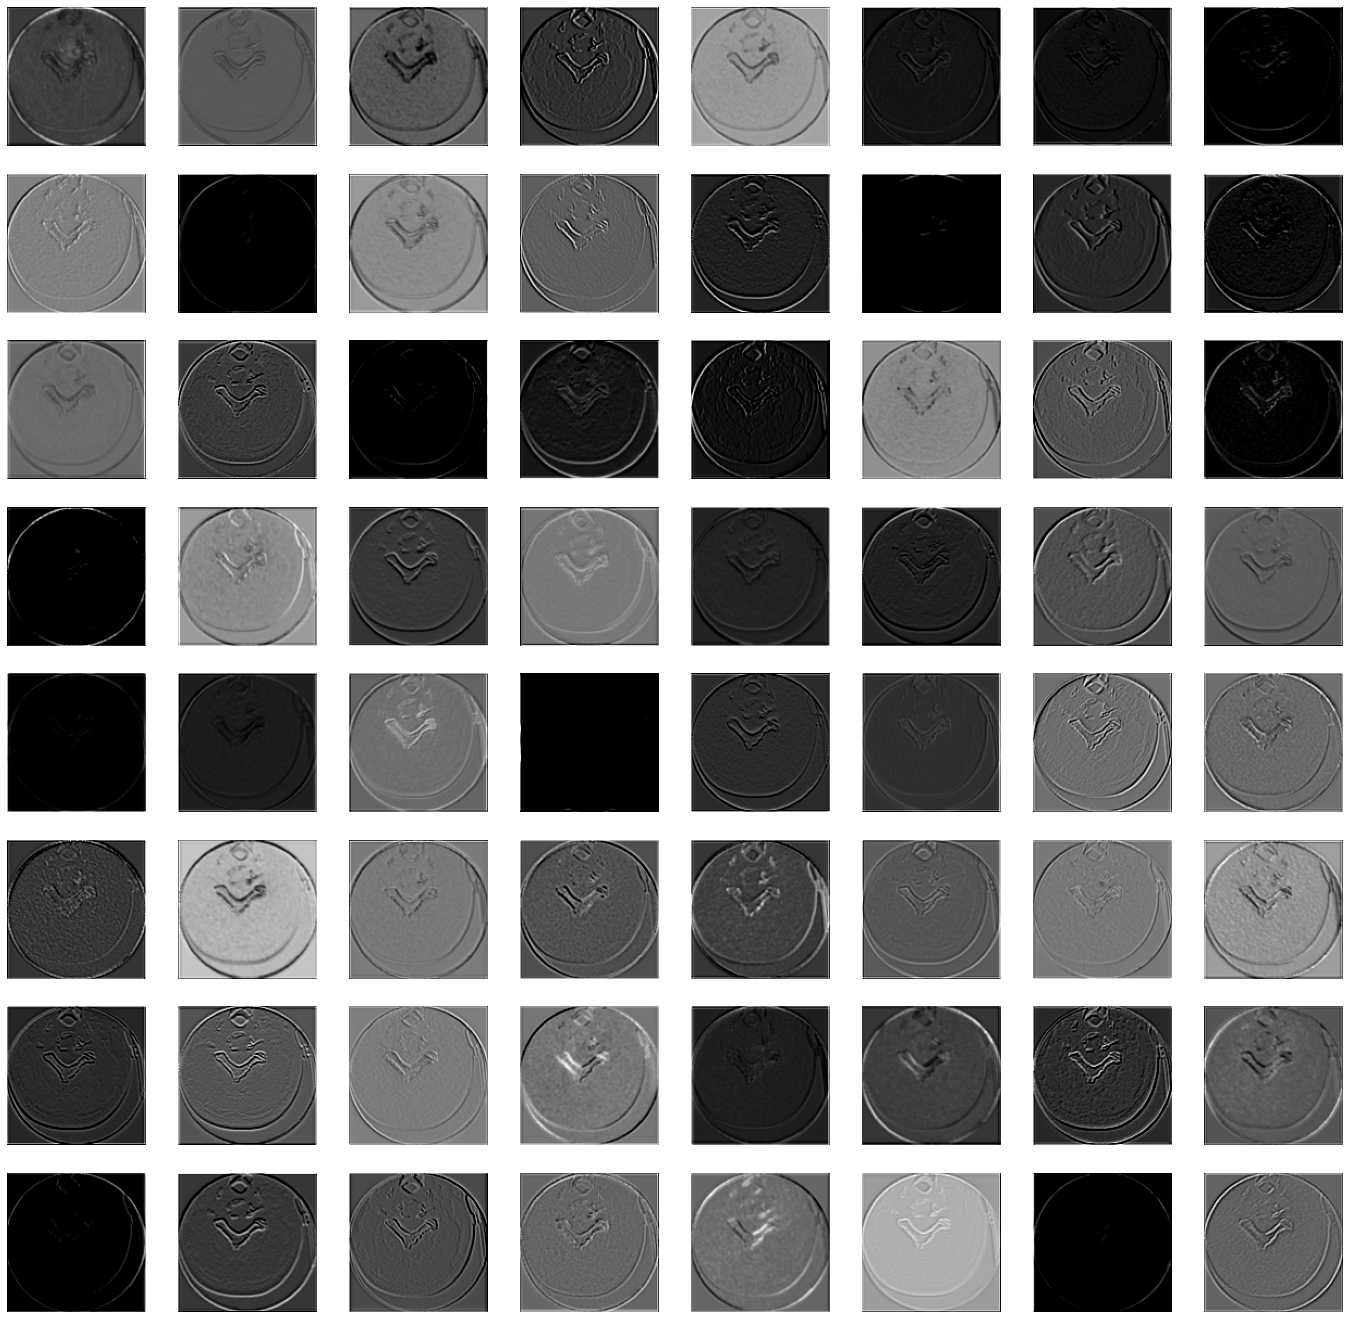

In [64]:
module_input, module_output = layer_input_output(model, model.layer1, torch.tensor(norm_imgs[[150], :, :]).unsqueeze(0).float())
fig, ax = plt.subplots(8, 8, figsize=(24, 24))
for i in range(64):
    ax[i // 8, i % 8].axis('off')
    ax[i // 8, i % 8].imshow(module_output[0, i, :, :], cmap='gray')

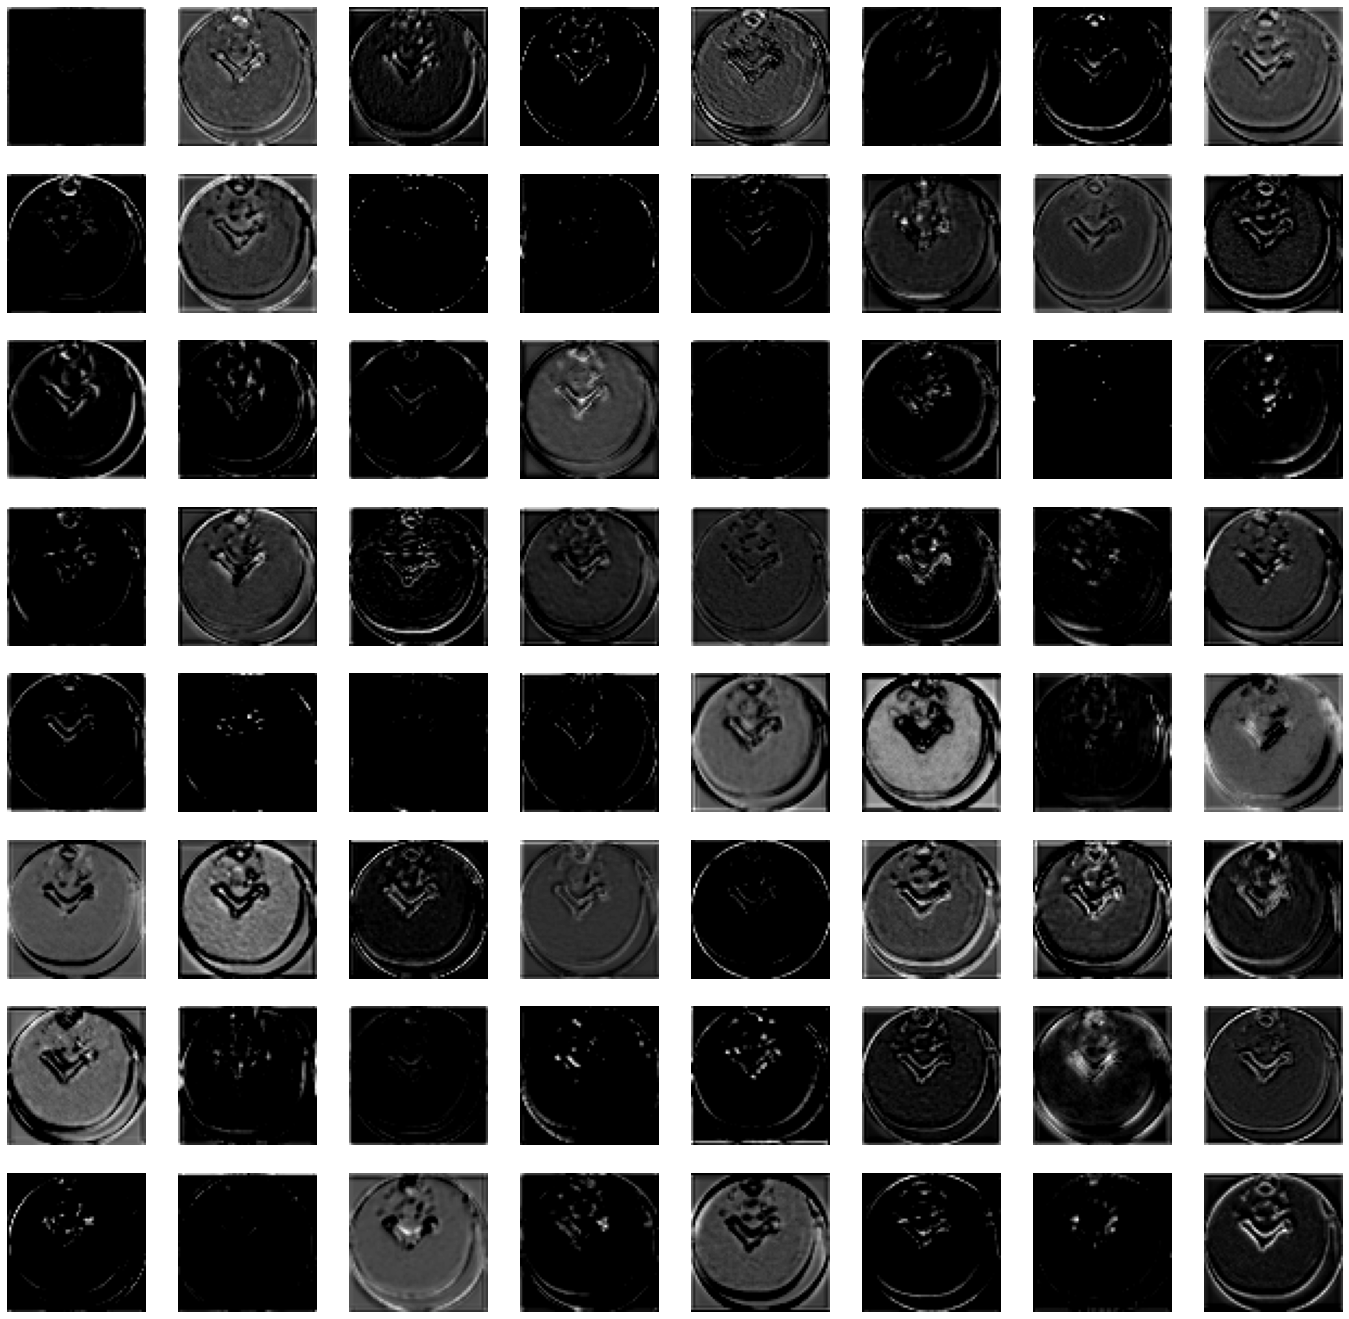

In [65]:
module_input, module_output = layer_input_output(model, model.layer2, torch.tensor(norm_imgs[[150], :, :]).unsqueeze(0).float())
fig, ax = plt.subplots(8, 8, figsize=(24, 24))
for i in range(64):
    ax[i // 8, i % 8].axis('off')
    ax[i // 8, i % 8].imshow(module_output[0, i, :, :], cmap='gray')

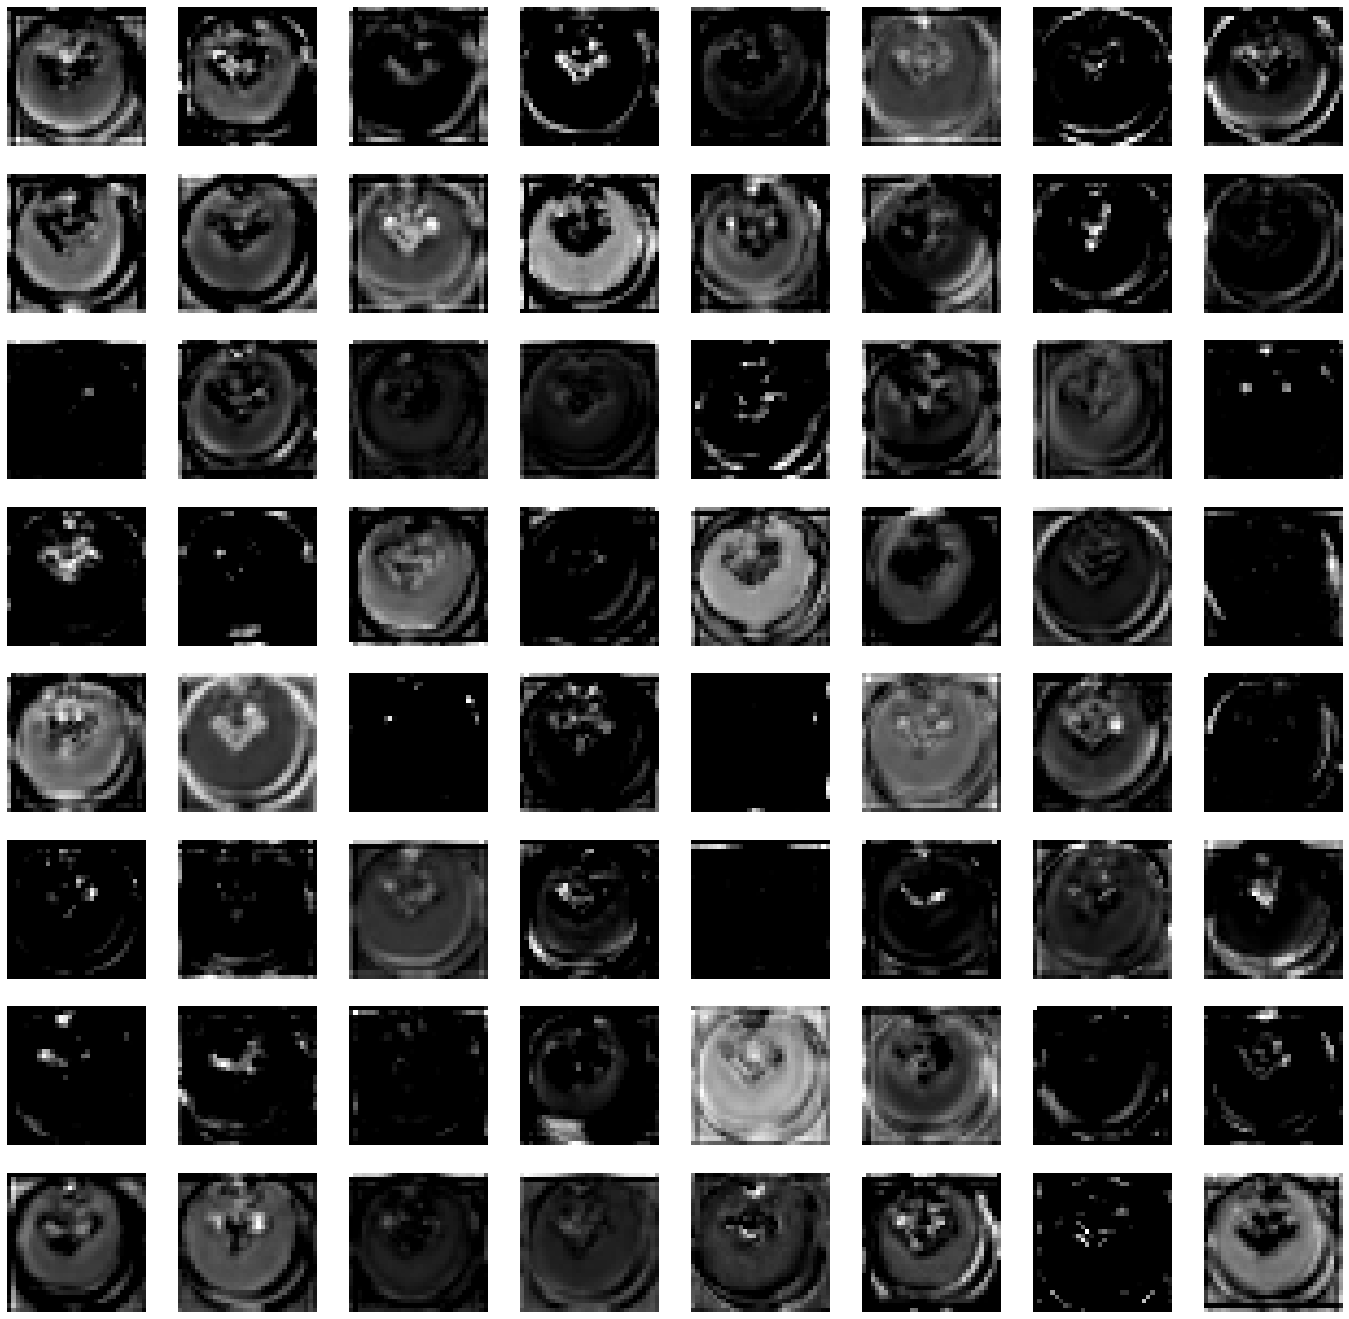

In [66]:
module_input, module_output = layer_input_output(model, model.layer3, torch.tensor(norm_imgs[[150], :, :]).unsqueeze(0).float())
fig, ax = plt.subplots(8, 8, figsize=(24, 24))
for i in range(64):
    ax[i // 8, i % 8].axis('off')
    ax[i // 8, i % 8].imshow(module_output[0, i, :, :], cmap='gray')

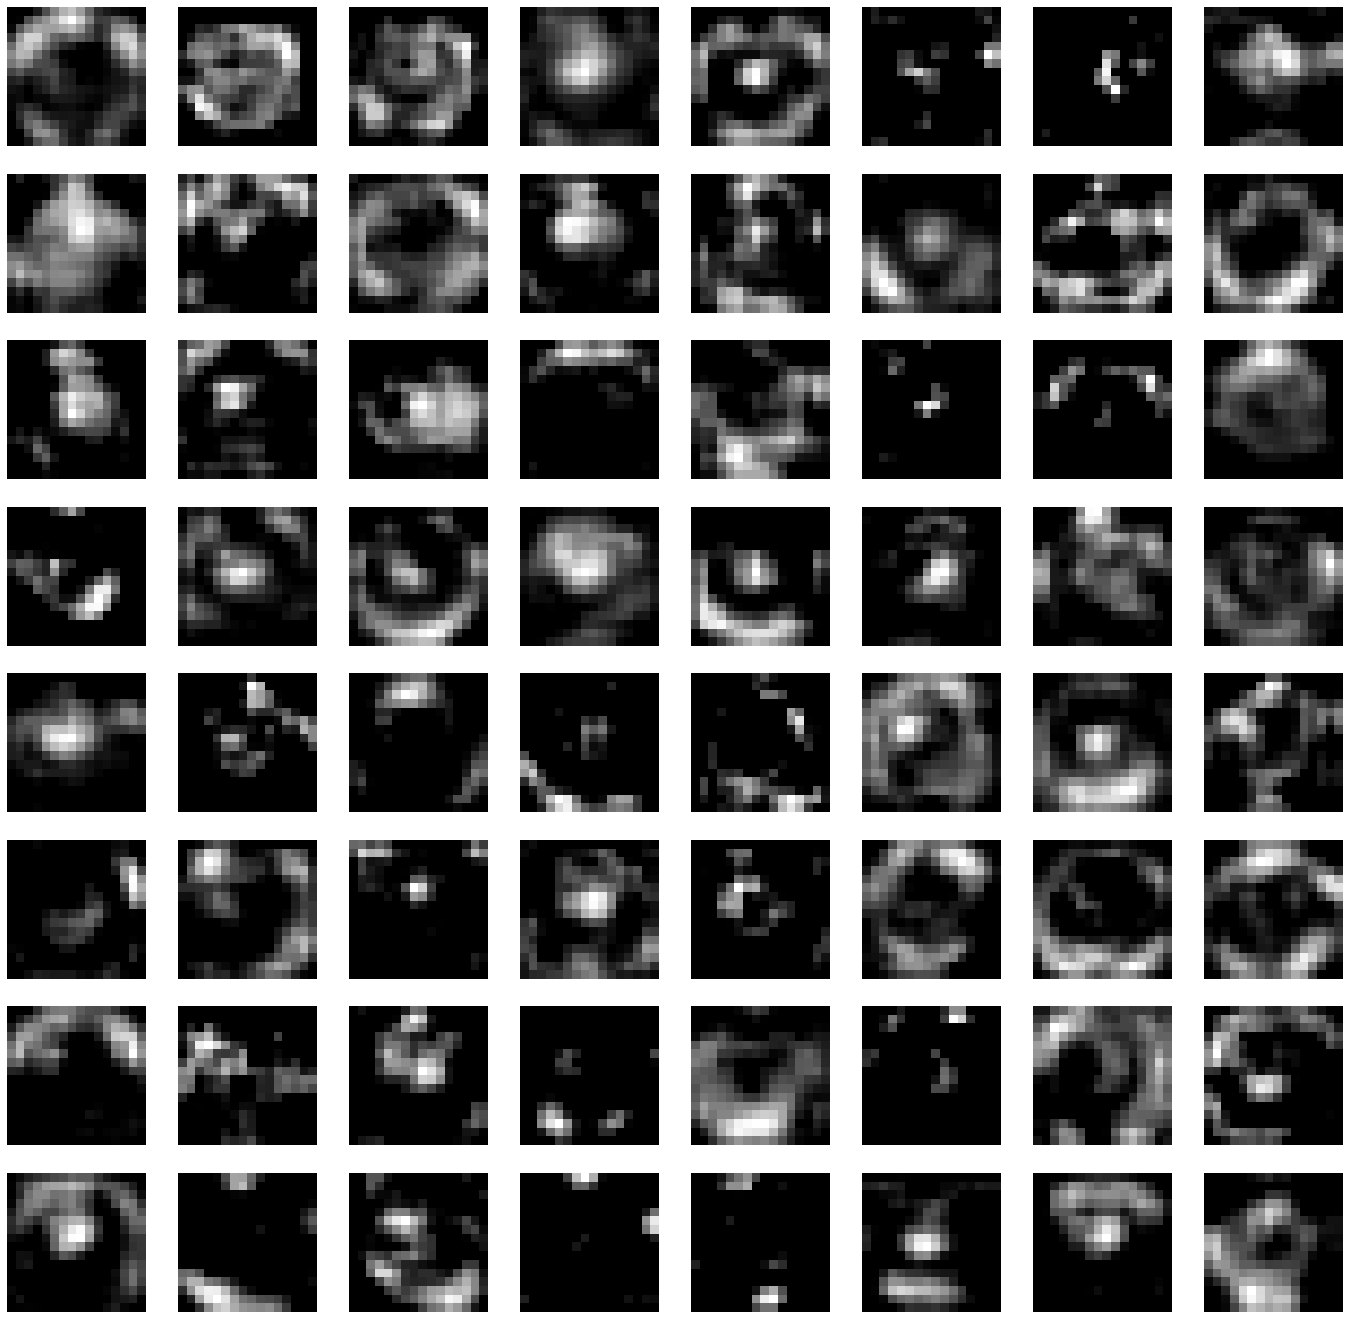

In [67]:
module_input, module_output = layer_input_output(model, model.layer4, torch.tensor(norm_imgs[[150], :, :]).unsqueeze(0).float())
fig, ax = plt.subplots(8, 8, figsize=(24, 24))
for i in range(64):
    ax[i // 8, i % 8].axis('off')
    ax[i // 8, i % 8].imshow(module_output[0, i, :, :], cmap='gray')